# Прогнозирование оттока клиентов из банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [54]:
# импорт библиотек
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None

import seaborn as sns
import os

In [55]:
# загрузка данных
if os.path.exists('/datasets/Churn.csv'):
    df = pd.read_csv('/datasets/Churn.csv')

else:
    df = pd.read_csv('/Users/olesya/datasets/Churn.csv')


In [56]:
# изучение таблицы
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [57]:
display(df.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Видим особенности, которые могут помешать нам в дальнейшем исследовании:

- NaN-значения в столбце Tenure
- Категориальные признаки - столбцы Geography и Gender
- Наличие излишних данных (столбцы RowNumber, CustomerId, Surname).

Сперва попробуем обработать пропуски в столбце Tenure. Заменим пропуски на ноль, предположим, что люди менее года являются клиентами бакнка.

In [58]:
df['Tenure'].fillna(-1, inplace=True)
#'.l m'

In [59]:
# замена типа данных на float
df.Tenure = df.Tenure.astype('object')

Обоснованно удалим столбцы Surname, RowNumber и CustomerId, так как эти данные не повлияют на дальнейшее исследование. 

In [60]:
# Удаление столбцов
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Преобразуем категориальные признаки в численные техникой прямого кодирования

In [61]:
# применение прямого кодирования техникой OHE
data_ohe = pd.get_dummies(df, drop_first=True)
display(data_ohe.head(10))

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_1.0,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0
0,619,42,0.00,1,1,1,101348.88,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,699,39,0.00,2,0,0,93826.63,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,645,44,113755.78,2,1,0,149756.71,1,0,1,...,0,0,0,0,0,0,0,1,0,0
6,822,50,0.00,2,1,1,10062.80,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,376,29,115046.74,4,1,0,119346.88,1,1,0,...,0,0,0,1,0,0,0,0,0,0
8,501,44,142051.07,2,0,1,74940.50,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,684,27,134603.88,1,1,1,71725.73,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Разделим данные на обучающую, валидационную и тестовую выборки в пропорциях (60%, 20% и 20%)

In [62]:
# создание переменных для признаков и целевого признака для обучающей выборки
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [63]:
# деление данных на обучающую, валидационную и тестовую выборки
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(6000, 21)
(2000, 21)
(2000, 21)


Маштабируем данные методом стандартизации

In [64]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [65]:
scaler =  StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,...,Tenure_1.0,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0
7479,-0.886751,-0.373192,1.232271,1,1,0,-0.187705,0,1,1,...,0,0,0,0,0,0,0,1,0,0
3411,0.608663,-0.183385,0.600563,1,0,0,-0.333945,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6027,2.052152,0.480939,1.027098,2,0,1,1.503095,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1247,-1.457915,-1.417129,-1.233163,2,1,0,-1.071061,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3716,0.130961,-1.132419,1.140475,1,0,0,1.524268,1,0,0,...,0,1,0,0,0,0,0,0,0,0


<b>Вывод</b>

- oзнакомились с данными,
- обработали пропуски, удалили лишние столбцы
- преобразовали категориальные признаки в количественные техникой прямого кодирования
- разбили данные на три выборки
- и маштабировали признаки методом стандартизации.

## Исследование задачи

### Решающее дерево

In [66]:
# обучение модели и расчёт accuracy на валидационной выборке
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=10)
model_tree.fit(features_train, target_train)

predicted_valid_tree = model_tree.predict(features_valid)

print("Accuracy модели Решающее дерево:", accuracy_score(predicted_valid_tree, target_valid))

Accuracy модели Решающее дерево: 0.8285


### Логистическая регрессия

In [67]:
# обучение модели и расчёт accuracy на валидационной выборке
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)

predicted_valid_lr = model_lr.predict(features_valid)

print("Accuracy модели Логистическая регрессия:", accuracy_score(predicted_valid_lr, target_valid))

Accuracy модели Логистическая регрессия: 0.7995


### Случайный лес

In [68]:
# обучение модели и расчёт accuracy на валидационной выборке
model_forest = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10) 
model_forest.fit(features_train, target_train)
# получение предсказаний модели
predicted_valid_forest = model_forest.predict(features_valid)

print("Accuracy модели Случайный лес:", accuracy_score(predicted_valid_forest, target_valid)) 

Accuracy модели Случайный лес: 0.862


Доля правильных ответов — 86%. Необходиом понять насколько это хорошо. Исследуем целевой признак.
Проверим, как часто в целевом признаке встречается класс «1» или «0». 

0    0.7963
1    0.2037
Name: Exited, dtype: float64


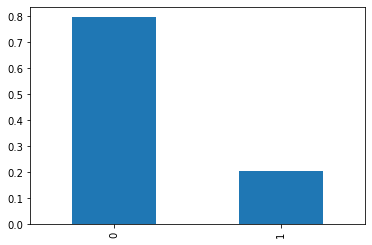

In [69]:
class_frequency = data_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar') ;

Классы несбалансированы, т.е. положительный класс "1" в четыре раза меньше отрицательного "0". (20% клиентов уходит). 

Теперь проанализируем частоты классов в результатах предсказаний на всех моделях.

0    0.8585
1    0.1415
dtype: float64


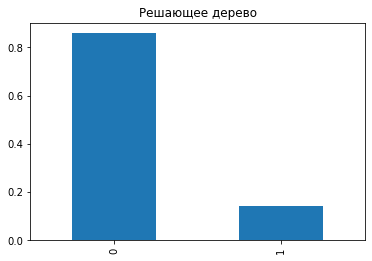

In [70]:
predicted_valid_tree = pd.Series(model_tree.predict(features_valid))

class_frequency_tree = predicted_valid_tree.value_counts(normalize=True)
print(class_frequency_tree)
class_frequency_tree.plot(kind='bar', title='Решающее дерево');

0    0.9105
1    0.0895
dtype: float64


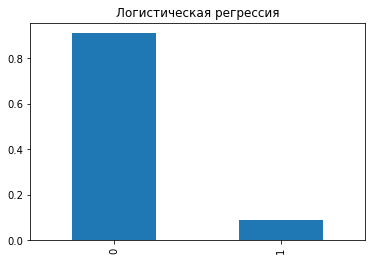

In [71]:
predicted_valid_lr = pd.Series(model_lr.predict(features_valid))

class_frequency_lr = predicted_valid_lr.value_counts(normalize=True)
print(class_frequency_lr)
class_frequency_lr.plot(kind='bar', title='Логистическая регрессия');

0    0.893
1    0.107
dtype: float64


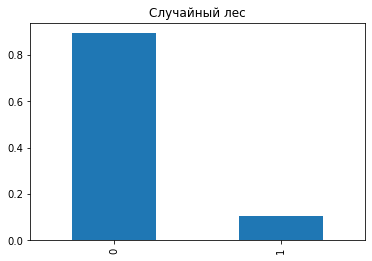

In [72]:
predicted_valid_forest = pd.Series(model_forest.predict(features_valid))

class_frequency_forest = predicted_valid_forest.value_counts(normalize=True)
print(class_frequency_forest)
class_frequency_forest.plot(kind='bar', title='Случайный лес');

Довольно высокие показатели предсказаний. Создадим константную модель, которя всегда предсказывает 0, посчитаем accuracy и сравним с построенными моделями.

In [73]:
target_pred_constant = pd.Series(0, index=target.index)
print(accuracy_score(target, target_pred_constant))

0.7963


Accuracy предсказания константной модели ниже 79%, значит построенные модели предсказывают лучше константной.

Расчитаем F1-меру (среднее гармоническое полноты и точности), чтобы оценить качество прогноза положительного класса с разных позиций.  

In [74]:
# расчет F1 меры для модели Решающее дерево
print(f1_score(target_valid, predicted_valid_tree))

0.5106990014265336


In [75]:
# расчет F1 меры для модели Логистическая регрессия
print(f1_score(target_valid, predicted_valid_lr))

0.32830820770519265


In [76]:
# расчет F1 меры для модели Случайный лес
print(f1_score(target_valid, predicted_valid_forest))

0.5632911392405064


<b>Вывод</b>

- исследовали баланс классов, выявили, что классы несбалансированы
- выяснили, что клиенты уходят в 20% процентах случаев, т.е. положительный класс в четыре раза меньше отрицательного
- изучили модели без учёта дисбаланса
- выяснили, что результат работы модели случайного леса лучше других.


## Борьба с дисбалансом

Постараемся улушить модель и достичь F1 меру не менее 0.59.

<b>1. Способ class_weight.</b> 

Сделаем веса классов сбалансированными с помощью аргумента class_weight. Придадим объектам редкого класса больший вес.

In [77]:
# балансировка веса классов модели Решающее дерево
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_tree = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_tree))

F1: 0.49172576832151305


In [78]:
# балансировка веса классов модели Логистическая регрессия 
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_lr = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_lr))

F1: 0.4891961970613656


In [79]:
# балансировка веса классов модели Случайный лес
best_model = None
best_result = 0
best_depth = 0
for est in range(100, 1001, 100):
    for depth in range(2, 12, 2):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        # обучение модели с заданной глубиной дерева
        model.fit(features_train, target_train)
        
        predicted_valid_forest = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid_forest)

        # определение лучшей F1 меры
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

print("F1 мера наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", 
      best_depth, "Количество деревьев:", best_est)


F1 мера наилучшей модели на валидационной выборке: 0.6390658174097664 Глубина дерева: 8 Количество деревьев: 100


Балансировка классов улучшила показатели. Лучшее значение F1 меры по прежнему у модели Слуайного леса и составляет 0.64.
Также нашли наилучшую модель с гиперпараметрами n_estimators=100 и max_depth=8.

<b>2. Способ upsampling.</b> 

Увеличим выборку путём копирования положительного класса.

In [80]:
# функция увеличения выборки техникой upsampling
def upsample(features, target, repeat):
    # деление выборки на отрицательные и положительные классы
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # создание новой выборки после объединения 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешивание
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [81]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [82]:
# проверка метода на модели Решающее дерево
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid_tree = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_tree))

F1: 0.47158403869407495


In [83]:
# проверка метода на модели Логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid_lr = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_lr))

F1: 0.4891961970613656


In [84]:
# проверка метода на модели Случайный лес
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8)
model.fit(features_upsampled, target_upsampled)
predicted_valid_forest = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_forest))

F1: 0.6048879837067209


В общем показатели стали немного хуже, чем у первого способа. Лучший показатель F1 меры у модели Случайный лес и составляет 0.61

<b>3. Способ downsampling.</b> 

Сделаем объекты частого класса "0" не такими частыми. Напишем функцию downsample.

In [85]:
# функция уменьшения выборки техникой downsampling
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [86]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [87]:
# проверка метода на модели Решающее дерево
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid_tree = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_tree))

F1: 0.49021276595744684


In [88]:
# проверка метода на модели Логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid_lr = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_lr))

F1: 0.48323301805674973


In [89]:
# проверка метода на модели Случайный лес
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8)
model.fit(features_downsampled, target_downsampled)
predicted_valid_forest = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_forest))

F1: 0.5966228893058161


Снова лидирует модель Случайный лес с результатом 0.59, но уменьшение выборки ухудшает результаты. Попробуем изменить порог.

<b>4. Способ изменение порога.<b>
    
Переберём значения порогов от 0 до 0.6 с шагом 0.05 и расчитаем значения F1 меры при каждом изменении.

In [90]:
# функция подсчёта F1 меры при разном значении порога
def probabilities(probabilities_one_valid):
    for threshold in np.arange(0, 0.6, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)  

        print("Порог = {:.2f} | F1 мера = {:.3f}".format(threshold, f1))

In [91]:
# проверка метода на модели Решающее дерево
model = DecisionTreeClassifier(random_state=12345, max_depth=10)
model.fit(features_train, target_train)
probabilities_valid_tree = model.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

In [92]:
probabilities(probabilities_one_valid_tree)

Порог = 0.00 | F1 мера = 0.391
Порог = 0.05 | F1 мера = 0.436
Порог = 0.10 | F1 мера = 0.526
Порог = 0.15 | F1 мера = 0.543
Порог = 0.20 | F1 мера = 0.540
Порог = 0.25 | F1 мера = 0.542
Порог = 0.30 | F1 мера = 0.536
Порог = 0.35 | F1 мера = 0.533
Порог = 0.40 | F1 мера = 0.520
Порог = 0.45 | F1 мера = 0.511
Порог = 0.50 | F1 мера = 0.511
Порог = 0.55 | F1 мера = 0.510


In [93]:
# проверка метода на модели Логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid_lr = model.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

In [94]:
probabilities(probabilities_one_valid_lr)

Порог = 0.00 | F1 мера = 0.346
Порог = 0.05 | F1 мера = 0.375
Порог = 0.10 | F1 мера = 0.422
Порог = 0.15 | F1 мера = 0.470
Порог = 0.20 | F1 мера = 0.482
Порог = 0.25 | F1 мера = 0.498
Порог = 0.30 | F1 мера = 0.493
Порог = 0.35 | F1 мера = 0.443
Порог = 0.40 | F1 мера = 0.399
Порог = 0.45 | F1 мера = 0.371
Порог = 0.50 | F1 мера = 0.328
Порог = 0.55 | F1 мера = 0.286


In [95]:
# проверка метода на модели Случайный лес
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8)
model.fit(features_train, target_train)
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [96]:
probabilities(probabilities_one_valid_forest)

Порог = 0.00 | F1 мера = 0.346
Порог = 0.05 | F1 мера = 0.363
Порог = 0.10 | F1 мера = 0.437
Порог = 0.15 | F1 мера = 0.532
Порог = 0.20 | F1 мера = 0.581
Порог = 0.25 | F1 мера = 0.627
Порог = 0.30 | F1 мера = 0.630
Порог = 0.35 | F1 мера = 0.618
Порог = 0.40 | F1 мера = 0.606
Порог = 0.45 | F1 мера = 0.568
Порог = 0.50 | F1 мера = 0.532
Порог = 0.55 | F1 мера = 0.450


Лучший результат у модели Случайный лес, что составляет 0.63 с порогом 0.30.

<b>Вывод</b>

Лучшие результаты борьбы с дисбалансом показал способ балансировка, применим его на тестовой выборке. И модель возьмём Случайный лес с гиперпараметрами n_estimators=100, max_depth=8.

## Тестирование модели

In [97]:
# проверка метода балансировка на тестовой выборке 
model_test = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8, class_weight='balanced')
model_test.fit(features_train, target_train)
predicted_test = model_test.predict(features_test)
probabilities_one_test = model_test.predict_proba(features_test)[:, 1]

print("F1:", f1_score(target_test, predicted_test))

F1: 0.5976520811099253


Удалось добиться необходимой метрики F1.

Посчитаем площадь под ROC-кривой для модели (AUC-ROC), чтобы узнать насколько сильно ее точность отличается от случайной.

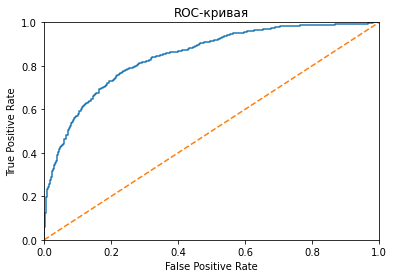

In [98]:

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [99]:
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

0.8453927692854284


Метрика лучше, чем у случайной модели.

<b>Общий вывод</b>

- Ознакомились с данными и подготовили их к исследованию (преобразовали категориальные признаки в численные с помощью техники прямого кодирования OHE, разбили получившийся датасет на 3 выборки - обучающую, валидационную и тестовую, масштабировали признаки методом стандартизации).
- Исследовали баланс классов - они оказались несбалансированы, изучили модели без учёта дисбаланса, выяснили, что результат работы модели случайного леса лучше.
- Применили 4 способа борбы с дисбалансом - аргумент class_weight, уменьшение выборки, увеличение выборки и изменение порога. Лучшие результаты показал способы борьбы с дисбалансом class_weight и изменение порога. Выявили лучшие значения n_estimators и max_depth для модели случайного леса.
- Обучили финальную модель и проверили ее на тестовой выборке. Достигли значения F1 = 0.6. Исследовали метрику AUC-ROC - ее значение  отличается от значения для случайной модели и составляет 0.85